In [1]:
"""
APPLY BAYESIAN NEURAL NETWORK ON APOGEE-TGAS DR14 DATA
"""
%matplotlib inline 
from scipy.stats import kde
import scipy
import CalcBNN3Layer as cbnn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Read data

In [2]:
# Read Vrard-APOKASC-TGAS with isochrone and ANN masses to calculate window for calculating ages
#header=np.hstack([["location_id","ra","dec","vlos","evlos","j","ej","h","eh","k","ek","teff",
#                   "teff_err","logg","logg_err","m_h","m_h_err","alpha_m","alpha_m_err",
#                   "[C/M]","[C/M]_err","[N/M]","[N/M]_err","ra_gaia","dec_gaia",
#                   "ra_error","dec_error","parallax","parallax_error","pmra","pmra_error",
#                   "pmdec","pmdec_error","meandist","diststd","mass","mass_error",
#                   "iso_mu_log10age","iso_sig_log10age","iso_mu_mh","iso_sig_mh",
#                   "iso_mu_log10mass","iso_sig_log10mass","iso_mu_dm","iso_sig_dm",
#                   "isonomass_mu_log10age","isonomass_sig_log10age","isonomass_mu_mh","isonomass_sig_mh",
#                   "isonomass_mu_log10mass","isonomass_sig_log10mass","isonomass_mu_dm","isonomass_sig_dm",
#                   "ann_mu_log10age","ann_sig_log10age","ann_mu_mh","ann_sig_mh",
#                   "ann_mu_log10mass","ann_sig_log10mass","ann_mu_dm","ann_sig_dm"]])
datafile   = "data/Vrard_APOKASC_TGAS_DR14_supp_seismo_masses_iso_ann.csv"
seismostar = pd.read_csv(datafile,header=0,index_col=0)
nseismostars = len(seismostar)
print("The number of stars in the Vrard_APOKASC_TGAS DR14 sample is:")
print(nseismostars) 
print(" ")

# Determine ANN window (some modified if age estimate bad)
inputsmin = np.array([min(seismostar["h"].values),
                      min(seismostar["j"].values-seismostar["k"].values),
                      min(seismostar["parallax"].values),
                      min(seismostar["logg"].values),
                      min(seismostar["teff"].values),
                      -1.0,
                      min(seismostar["alpha_m"].values),
                      min(seismostar["[C/M]"].values),
                      min(seismostar["[N/M]"].values)])
inputsmax = np.array([max(seismostar["h"].values),
                      max(seismostar["j"].values-seismostar["k"].values),
                      max(seismostar["parallax"].values),
                      max(seismostar["logg"].values),
                      max(seismostar["teff"].values),
                      max(seismostar["m_h"].values),
                      max(seismostar["alpha_m"].values),
                      max(seismostar["[C/M]"].values),
                      max(seismostar["[N/M]"].values)])

#("location_id","ra","dec","vlos","evlos","j","ej","h","eh","k","ek","teff","teff_err","logg",
# "logg_err","m_h","m_h_err","alpha_m","alpha_m_err"],elarrdef,elarrdef_err,["ra_gaia",
# "dec_gaia","ra_error","dec_error","parallax","parallax_error","pmra","pmra_error","pmdec",
# "pmdec_error","meandist","diststd","mass","mass_error"])
datafile = "data/APOGEE_TGAS_DR14_supp_seismo_masses.csv"
star     = pd.read_csv(datafile,header=0,index_col=0) 
nstars   = len(star)      
print("The number of stars in the APOGEE-TGAS DR14 sample is:")
print(nstars) 
print(" ")

The number of stars in the Vrard_APOKASC_TGAS DR14 sample is:
1214
 
The number of stars in the APOGEE-TGAS DR14 sample is:
10074
 


(array([  4.,   2.,  10.,  12.,  69., 736., 214.,  86.,  73.,   8.]),
 array([1.31409 , 1.523772, 1.733454, 1.943136, 2.152818, 2.3625  ,
        2.572182, 2.781864, 2.991546, 3.201228, 3.41091 ]),
 <a list of 10 Patch objects>)

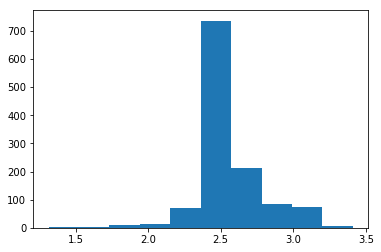

In [3]:
plt.hist(seismostar["logg"].values)

# Select inputs

In [4]:
# Select neural network inputs and errors
inputs = np.column_stack((star["h"].values,
                          star["j"].values-star["k"].values,
                          star["parallax"].values,
                          star["logg"].values,
                          star["teff"].values,
                          star["m_h"].values,
                          star["alpha_m"].values,
                          star["[C/M]"].values,
                          star["[N/M]"].values))

ninputs = len(inputs[0,:])
print "Number of inputs: ", ninputs

errJminK = np.sqrt(star["ej"].values**2. + star["ek"].values**2.)
errInputs = np.column_stack((star["eh"].values,
                             errJminK,
                             star["parallax_error"].values,
                             star["logg_err"].values,
                             star["teff_err"].values,
                             star["m_h_err"].values,
                             star["alpha_m_err"].values,
                             star["err_[C/M]"].values,
                             star["err_[N/M]"].values))

# Calculate number of stars with good data and within window of ANN training sample
iwind         = (inputs > inputsmin) & (inputs < inputsmax)
iwindprod     = np.prod(iwind,axis=1)
iwindprodbool = np.ma.make_mask(iwindprod)
inputs        = inputs[iwindprodbool,:]
errInputs     = errInputs[iwindprodbool,:]
nstars,tmp    = np.shape(inputs)
print ("Number of stars within ANN window: "+str(nstars))

igoodstar = iwindprodbool &\
            ~(star["j"]==-9999) & ~(star["h"]==-9999) &\
            ~(star["k"]==-9999) & ~(star["parallax"]==-9999) &\
            ~(star["logg"]==-9999) & ~(star["teff"]==-9999) &\
            ~(star["m_h"]==-9999) & ~(star["[C/M]"]==-9999) &\
            ~(star["[N/M]"]==-9999) & ~(star["alpha_m"]==-9999) &\
            ~(star["ej"]==-9999) & ~(star["eh"]==-9999) &\
            ~(star["ek"]==-9999) & ~(star["parallax_error"]==-9999) &\
            ~(star["logg_err"]==-9999) & ~(star["teff_err"]==-9999) &\
            ~(star["m_h_err"]==-9999) & ~(star["err_[C/M]"]==-9999) &\
            ~(star["err_[N/M]"]==-9999) & ~(star["alpha_m_err"]==-9999)
print("The number of stars in the APOGEE-TGAS DR14 sample for which we can calculate good masses, ages, and distances is:")
print(np.sum(igoodstar)) 

Number of inputs:  9
Number of stars within ANN window: 9403
The number of stars in the APOGEE-TGAS DR14 sample for which we can calculate good masses, ages, and distances is:
9403


# Calculate masses, ages, distances, and metallicity

In [5]:
# Instantiate class
bnn = cbnn.CalcBNN3Layer()

# Number of neurons per hidden layer
neuronsPerHiddenlayer = 10

# Whether to use NUTS or ADVI sampler
sampler               = "nuts"

# Number of samples drawn from posterior
nsamp                 = 10000

# Pickle file for storing model
tracedir = "results/bnn/"
bnnmodelpkl = tracedir+"bnn_"+sampler+"_ninputs"+str(ninputs)+"_nhid"+str(neuronsPerHiddenlayer)+"_nsamp"+str(nsamp)+".pkl"
print(bnnmodelpkl)

# Number of posterior predictive samples
nppc = 1000 

# Apply model
out = bnn.calcPostPredSamples(bnnmodelpkl,inputs,errInputs,nppc)

inputsTrueMu   = out["InputsTrueMu"]
inputsTrueSig  = out["InputsTrueSig"]
targetsTrueMu  = out["TargetsTrueMu"]
targetsTrueSig = out["TargetsTrueSig"]

tmp,ntargets   = np.shape(targetsTrueSig)

100%|██████████| 1000/1000 [00:47<00:00, 21.03it/s]

results/bnn/bnn_nuts_ninputs9_nhid10_nsamp10000.pkl


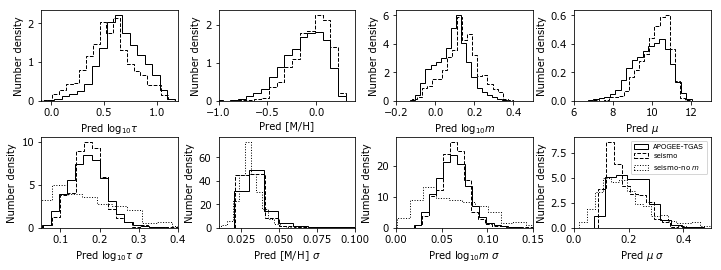

In [6]:
# Plot histograms
plotlabels = [r"$\log_{10}\tau$", "[M/H]", r"$\log_{10}m$",r"$\mu$"]
plt.rc('font',family='verdana')  
nx    = 2
ny    = 4
seismodatamu  = np.column_stack((seismostar["ann_mu_log10age"],
                                 seismostar["ann_mu_mh"],
                                 seismostar["ann_mu_log10mass"],
                                 seismostar["ann_mu_dm"]))
seismodatasig = np.column_stack((seismostar["ann_sig_log10age"],
                                 seismostar["ann_sig_mh"],
                                 seismostar["ann_sig_log10mass"],
                                 seismostar["ann_sig_dm"]))
seismodataNomassmu  = np.column_stack((seismostar["isonomass_mu_log10age"],
                                 seismostar["isonomass_mu_mh"],
                                 seismostar["isonomass_mu_log10mass"],
                                 seismostar["isonomass_mu_dm"]))
seismodataNomasssig = np.column_stack((seismostar["isonomass_sig_log10age"],
                                 seismostar["isonomass_sig_mh"],
                                 seismostar["isonomass_sig_log10mass"],
                                 seismostar["isonomass_sig_dm"]))
axislim    = np.array([[-0.1,1.2],[-1.0,0.4],[-0.2,0.5],[6,13]])
erraxislim = np.array([[0.05,0.4],[0.01,0.1],[0.0,0.15],[0.0,0.5]])
fig,axarr = plt.subplots(nx,ny,figsize=(12,4))  
for jy in range(ntargets):
    axarr[0,jy].hist(targetsTrueMu[:,jy],bins=20,histtype="step",color="k",normed=True)
    axarr[0,jy].hist(seismodatamu[:,jy],bins=20,histtype="step",color="k",
                     linestyle="--",normed=True)
    axarr[0,jy].set_xlim(axislim[jy,:])
    axarr[0,jy].set_xlabel("Pred "+plotlabels[jy],fontsize=10)
    axarr[0,jy].set_ylabel("Number density",fontsize=10)
    
    if ((jy==1)|(jy==3)):
        axarr[1,jy].hist(targetsTrueSig[:,jy],bins=80,histtype="step",color="k",normed=True,
                        label="APOGEE-TGAS")
        axarr[1,jy].hist(seismodatasig[:,jy],bins=80,histtype="step",color="k",
                         linestyle="--",normed=True,label="seismo")
        axarr[1,jy].hist(seismodataNomasssig[:,jy],bins=20,histtype="step",color="k",
                         linestyle=":",normed=True,label=r"seismo-no $m$")
    else:
        axarr[1,jy].hist(targetsTrueSig[:,jy],bins=20,histtype="step",color="k",normed=True)
        axarr[1,jy].hist(seismodatasig[:,jy],bins=20,histtype="step",color="k",
                         linestyle="--",normed=True)
        axarr[1,jy].hist(seismodataNomasssig[:,jy],bins=16,histtype="step",color="k",
                         linestyle=":",normed=True)
    axarr[1,jy].set_xlim(erraxislim[jy,:])
    axarr[1,jy].set_xlabel("Pred "+plotlabels[jy]+r" $\sigma$",fontsize=10)
    axarr[1,jy].set_ylabel("Number density",fontsize=10)
    fig.subplots_adjust(hspace=0.4,wspace=0.3)
axarr[1,3].legend(fontsize=7)    
plotfile = "plots/APOGEE_TGAS_DR14_"+sampler+"_ninputs"+str(ninputs)+"_nhid"+str(neuronsPerHiddenlayer)+"_nsamp"+str(nsamp)+".eps"
fig.savefig(plotfile,format='eps',bbox_inches='tight',rasterized=True)

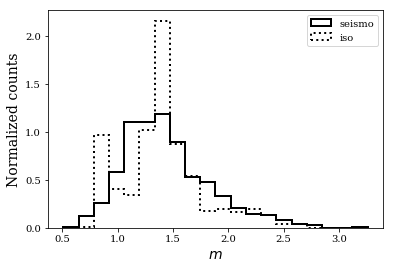

In [56]:
# Create histogram comparing asteroseismology masses, isochrone masses, and ANN masses
seismomass = seismostar["mass"]
isomass    = 10.**seismostar["iso_mu_log10mass"]      
annmass    = 10.**seismostar["ann_mu_log10mass"]    
apogeemass = 10.**targetsTrueMu[:,2]

plt.rc('font',family='serif')
fig = plt.figure(figsize=(6,4))
n,bins,patches = plt.hist(seismomass,histtype="step",bins=20,normed=True,linewidth=2,
                          color="black",label="seismo")
plt.hist(isomass,histtype="step",bins=bins,normed=True,linewidth=2,linestyle=":",color="black",label="iso")
#plt.hist(annmass,histtype="step",bins=bins,normed=True,linewidth=2,linestyle="--",color="black",label="ANN")
#plt.hist(apogeemass,histtype="step",bins=bins,normed=True,linewidth=2,linestyle="-",color="red",label="APOGEE-TGAS")
plt.xlabel(r"$m$",fontsize=14)
plt.ylabel("Normalized counts",fontsize=14)
plt.legend()
plotfile = "plots/bnn/massdist_"+sampler+"_ninputs"+str(ninputs)+"_nhid"+str(neuronsPerHiddenlayer)+"_nsamp"+str(nsamp)+".eps"
fig.savefig(plotfile,format='eps',bbox_inches='tight')

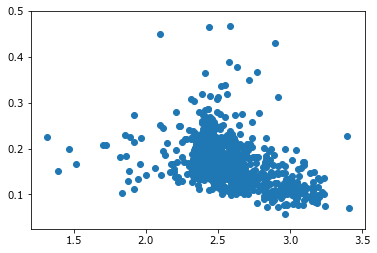

In [7]:
plt.scatter(seismostar["logg"],seismostar["ann_sig_log10age"])

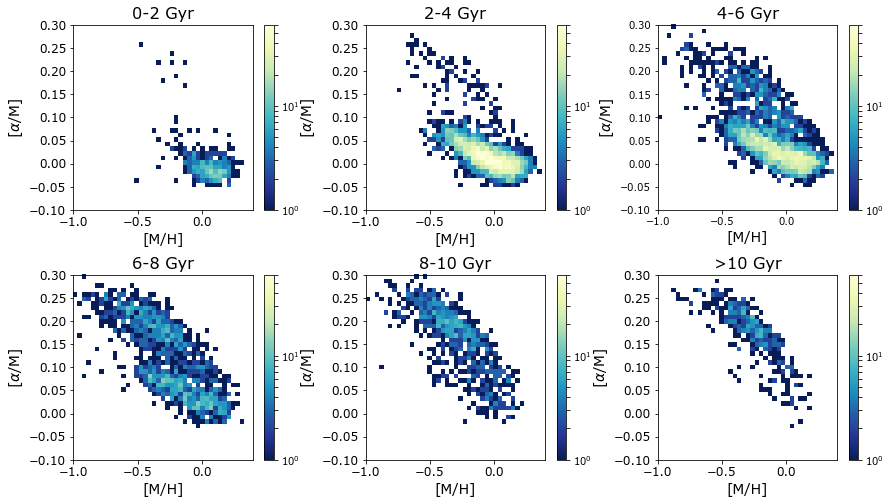

In [90]:
#%% Plots of [M/H]-[a/M] in age slices

agemu  = 10**targetsTrueMu[:,0]   
mh     = star["m_h"][igoodstar]
am     = star["alpha_m"][igoodstar]
mhmin  = -1.0
mhmax  = 0.4
ammin  = -0.1
ammax  = 0.3
nmin   = 1
nmax   = 60
binsize = 10.
plt.rc('font',family='verdana')  
fig2  = plt.figure(figsize=(14.5,8)) 
fig2.subplots_adjust(hspace=0.35,wspace=0.3)

ax1 = plt.subplot(2,3,1) 
ax1.set_rasterized(True)
stellagebin1 = (~np.isnan(agemu) & \
              (agemu>0.) & 
              (agemu<2.))  
plt.hist2d(mh[stellagebin1],am[stellagebin1],
           np.int(np.sum(stellagebin1)/binsize),
           range=([(mhmin,mhmax),(amin,amax)]),
           cmap="YlGnBu_r",norm=LogNorm(),vmin=nmin,vmax=nmax)
plt.xlabel("[M/H]", fontsize=14)
plt.ylabel(r"[$\alpha$/M]", fontsize=14)
plt.xlim(mhmin,mhmax)
plt.ylim(amin,amax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("0-2 Gyr",fontsize=16)
cbar=plt.colorbar()

ax2=plt.subplot(2,3,2) 
ax2.set_rasterized(True)
stellagebin2 = (~np.isnan(agemu) & \
                         (agemu>2.) & \
                         (agemu<4.))
plt.hist2d(mh[stellagebin2],am[stellagebin2],
           np.int(np.sum(stellagebin1)/binsize),
           range=([(mhmin,mhmax),(amin,amax)]),
           cmap="YlGnBu_r",norm=LogNorm(),vmin=nmin,vmax=nmax)
plt.xlabel("[M/H]", fontsize=14,zorder=1)
plt.ylabel(r"[$\alpha$/M]", fontsize=14)
plt.xlim(mhmin,mhmax)
plt.ylim(amin,amax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("2-4 Gyr",fontsize=16)
cbar=plt.colorbar()

ax3=plt.subplot(2,3,3) 
ax3.set_rasterized(True)
stellagebin3 = (~np.isnan(agemu) & \
                (agemu>4.) & \
                (agemu<6.))
plt.hist2d(mh[stellagebin3],am[stellagebin3],
           np.int(np.sum(stellagebin1)/binsize),
           range=([(mhmin,mhmax),(amin,amax)]),
           cmap="YlGnBu_r",norm=LogNorm(),vmin=nmin,vmax=nmax)
plt.xlabel("[M/H]", fontsize=14)
plt.ylabel(r"[$\alpha$/M]", fontsize=14)
plt.xlim(mhmin,mhmax)
plt.ylim(amin,amax)
plt.title("4-6 Gyr",fontsize=16)
cbar=plt.colorbar()

ax4=plt.subplot(2,3,4) 
ax4.set_rasterized(True)
stellagebin4 = (~np.isnan(agemu) & \
                         (agemu>6.) & \
                         (agemu<8.))
plt.hist2d(mh[stellagebin4],am[stellagebin4],
           np.int(np.sum(stellagebin1)/binsize),
           range=([(mhmin,mhmax),(amin,amax)]),
           cmap="YlGnBu_r",norm=LogNorm(),vmin=nmin,vmax=nmax)
plt.xlabel("[M/H]", fontsize=14)
plt.ylabel(r"[$\alpha$/M]", fontsize=14)
plt.xlim(mhmin,mhmax)
plt.ylim(amin,amax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("6-8 Gyr",fontsize=16)
cbar=plt.colorbar()

ax5=plt.subplot(2,3,5) 
ax5.set_rasterized(True)
stellagebin5 = (~np.isnan(agemu) & \
                         (agemu>8.) & \
                         (agemu<10.))
plt.hist2d(mh[stellagebin5],am[stellagebin5],
           np.int(np.sum(stellagebin1)/binsize),
           range=([(mhmin,mhmax),(amin,amax)]),
           cmap="YlGnBu_r",norm=LogNorm(),vmin=nmin,vmax=nmax)
plt.xlabel("[M/H]", fontsize=14)
plt.ylabel(r"[$\alpha$/M]", fontsize=14)
plt.xlim(mhmin,mhmax)
plt.ylim(amin,amax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("8-10 Gyr",fontsize=16)
cbar=plt.colorbar()

ax6 = plt.subplot(2,3,6) 
stellagebin6 = (~np.isnan(agemu) & \
                         (agemu>10.))
plt.hist2d(mh[stellagebin6],am[stellagebin6],
           np.int(np.sum(stellagebin1)/binsize),
           range=([(mhmin,mhmax),(amin,amax)]),
           cmap="YlGnBu_r",norm=LogNorm(),vmin=nmin,vmax=nmax)
plt.xlabel("[M/H]", fontsize=14)
plt.ylabel(r"[$\alpha$/M]", fontsize=14)
plt.xlim(mhmin,mhmax)
plt.ylim(amin,amax)
plt.title(">10 Gyr",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar=plt.colorbar()
ax6.set_rasterized(True)

fig2.savefig("plots/mh_am_ageslices.eps",bbox_inches="tight",dpi=180)

In [83]:
# File header
header=np.hstack([["location_id","ra","dec","vlos","evlos","j","ej","h","eh","k","ek","teff",
                   "teff_err","logg","logg_err","m_h","m_h_err","alpha_m","alpha_m_err",
                   "[C/M]","[C/M]_err","[N/M]","[N/M]_err","ra_gaia","dec_gaia",
                   "ra_error","dec_error","parallax","parallax_error","pmra","pmra_error",
                   "pmdec","pmdec_error","meandist","diststd","mass","mass_error",
                   "ann_mu_log10age","ann_sig_log10age","ann_mu_mh","ann_sig_mh",
                   "ann_mu_log10mass","ann_sig_log10mass","ann_mu_dm","ann_sig_dm"]])
catalog = np.column_stack((star["location_id"][igoodstar],
                           star["ra"][igoodstar],star["dec"][igoodstar],
                           star["vlos"][igoodstar],star["evlos"][igoodstar],
                           star["j"][igoodstar],star["ej"][igoodstar],
                           star["h"][igoodstar],star["eh"][igoodstar],
                           star["k"][igoodstar],star["ek"][igoodstar],
                           star["teff"][igoodstar],star["teff_err"][igoodstar],
                           star["logg"][igoodstar],star["logg_err"][igoodstar],
                           star["m_h"][igoodstar],star["m_h_err"][igoodstar],
                           star["alpha_m"][igoodstar],star["alpha_m_err"][igoodstar],
                           star["[C/M]"][igoodstar],star["err_[C/M]"][igoodstar],
                           star["[N/M]"][igoodstar],star["err_[N/M]"][igoodstar],
                           star["ra_gaia"][igoodstar],star["dec_gaia"][igoodstar],
                           star["ra_error"][igoodstar],star["dec_error"][igoodstar],
                           star["parallax"][igoodstar],star["parallax_error"][igoodstar],
                           star["pmra"][igoodstar],star["pmra_error"][igoodstar],
                           star["pmdec"][igoodstar],star["pmdec_error"][igoodstar],
                           star["meandist"][igoodstar],star["diststd"][igoodstar],
                           star["mass"][igoodstar],star["mass_error"][igoodstar],
                           targetsTrueMu[:,0],targetsTrueSig[:,0],
                           targetsTrueMu[:,1],targetsTrueSig[:,1],
                           targetsTrueMu[:,2],targetsTrueSig[:,2],
                           targetsTrueMu[:,3],targetsTrueSig[:,3]))

catalog_df = pd.DataFrame(data=catalog,index=None,columns=header)
datafile   = "data/APOGEE_TGAS_DR14_masses_ann.csv"
catalog_df.to_csv(datafile,sep=',',na_rep='nan',float_format='%15.5e',columns=header,header=True,index=True)